## Predict Credit Card Approval

### Import Libraries

In [28]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### UDFs

In [29]:
def count_plot(x, dataframe, ax=None, **kwargs):
    if len(kwargs)==1 and kwargs['mode']=='horizontal':
        sns.countplot(y=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    else:
        sns.countplot(x=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vbar_plot(dataframe, value, index, column, xlabel, fig_size, with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features, target):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df[target] == 0]
    t1 = df.loc[df[target] == 1]

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], label="0", legend=True)
        sns.kdeplot(t1[feature], label="1", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None


def clipping(dataframe, num_cols):
    df_copy = dataframe.copy()
    for col in num_cols:
        p25 = np.percentile(df_copy[col], 25)
        p75 = np.percentile(df_copy[col], 75)
        iqr = p75 - p25
        df_copy[col] = np.clip(df_copy[col], a_min=np.floor((p25 - 1.5*iqr)), a_max=np.ceil((p75 + 1.5*iqr)))
    return df_copy


def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = col + '_CAT'
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df


def feat_import(model, x_train):
    importance = model.feature_importances_
    imp=list(importance)
    feature_set=x_train.columns
    
    imp_df=pd.DataFrame({'Feature':feature_set,'Importance':imp})
    imp_df=imp_df.sort_values(by='Importance',ascending=False)
    
    return imp_df

### Configurations

In [30]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### Load Data

In [31]:
application_df = pd.read_csv('./data/application_record.csv')

application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [32]:
credit_df = pd.read_csv('./data/credit_record.csv')

credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### Data Pre-processing

In [33]:
# Drop duplicate applications
application_df = application_df.drop_duplicates(subset='ID', keep='last')

In [34]:
# Target label creation - target=1 (high risk) iff there is at least one month where user is late on payments by 30 days or more
credit_df['target_status'] = np.where((credit_df['STATUS']=='0')|(credit_df['STATUS']=='C')|(credit_df['STATUS']=='X'), 0, 1)
target_df=pd.DataFrame(credit_df.groupby(['ID'])['target_status'].agg(max)).reset_index()

# Merge target label to application dataset
merged_df = pd.merge(application_df, target_df, how='inner', on='ID')
merged_df['target_status'] = merged_df['target_status'].astype("category")

merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target_status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [35]:
# Fill missing values
merged_df['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [36]:
# Derive new features
merged_df = get_category(merged_df, col='AMT_INCOME_TOTAL', binsnum=3, labels=["low","medium", "high"], qcut = True)

In [37]:
# Data transformation
merged_df['DAYS_BIRTH'] = -1 * merged_df['DAYS_BIRTH']
merged_df['DAYS_EMPLOYED'] = -1 * merged_df['DAYS_EMPLOYED']
merged_df['DAYS_EMPLOYED'] = np.where((merged_df['DAYS_EMPLOYED']<=0), 0, merged_df['DAYS_EMPLOYED'])

In [38]:
cat_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'AMT_INCOME_TOTAL_CAT']

dropped_cat_features = ['FLAG_MOBIL', 'OCCUPATION_TYPE']

num_features = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

dropped_num_features = ['CNT_CHILDREN']

all_features = num_features + cat_features

In [39]:
# Handle outliers
merged_df = clipping(dataframe=merged_df, num_cols=num_features)

In [40]:
merged_df[num_features].describe().applymap('{:,.2f}'.format)

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,"36,457.00","36,457.00","36,457.00","36,457.00"
mean,"181,444.88","15,975.17","2,099.48",2.19
std,"81,183.28","4,200.55","2,046.72",0.89
min,"27,000.00","7,489.00",0.00,1.00
25%,"121,500.00","12,462.00",408.00,2.00
50%,"157,500.00","15,563.00","1,552.00",2.00
75%,"225,000.00","19,438.00","3,153.00",3.00
max,"380,250.00","25,152.00","7,271.00",5.00


In [41]:
merged_df[cat_features] = merged_df[cat_features].astype("category")
merged_df[cat_features].describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,AMT_INCOME_TOTAL_CAT
count,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457
unique,2,2,2,5,5,5,6,2,2,2,3
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,0,0,0,low
freq,24430,22614,24506,18819,24777,25048,32548,28235,25709,33186,14473


In [42]:
# Label encode categorical features
to_label_encode = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

for feature in to_label_encode:
    labelencoder = LabelEncoder()
    merged_df[feature] = labelencoder.fit_transform(merged_df[feature])

In [43]:
# Ordinal encode CO features - NAME_EDUCATION_TYPE, AMT_INCOME_TOTAL_CAT
edu_type_oe = OrdinalEncoder(categories=[['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']], dtype='int32')
merged_df['NAME_EDUCATION_TYPE'] = edu_type_oe.fit_transform(np.array(merged_df['NAME_EDUCATION_TYPE']).reshape(-1,1))

incm_cat_oe = OrdinalEncoder(categories=[["low","medium", "high"]], dtype='int32')
merged_df["AMT_INCOME_TOTAL_CAT"] = incm_cat_oe.fit_transform(np.array(merged_df['AMT_INCOME_TOTAL_CAT']).reshape(-1,1))

In [44]:
merged_df.shape

(36457, 20)

In [45]:
# One-hot encode nominal features
to_onehot_encode = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'] #, 'OCCUPATION_TYPE'

merged_df = pd.get_dummies(data=merged_df, prefix=['inc_typ', 'fam_sta', 'hou_typ'], columns=to_onehot_encode) #, 'occu_typ'

print("Dataset shape: {}".format(merged_df.shape))

merged_df.head()

Dataset shape: (36457, 33)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target_status,AMT_INCOME_TOTAL_CAT,inc_typ_Commercial associate,inc_typ_Pensioner,inc_typ_State servant,inc_typ_Student,inc_typ_Working,fam_sta_Civil marriage,fam_sta_Married,fam_sta_Separated,fam_sta_Single / not married,fam_sta_Widow,hou_typ_Co-op apartment,hou_typ_House / apartment,hou_typ_Municipal apartment,hou_typ_Office apartment,hou_typ_Rented apartment,hou_typ_With parents
0,5008804,1,1,1,0,380250.0,3,12005,4542,1,1,0,0,Other,2.0,1,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,5008805,1,1,1,0,380250.0,3,12005,4542,1,1,0,0,Other,2.0,1,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,5008806,1,1,1,0,112500.0,1,21474,1134,1,0,0,0,Security staff,2.0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,5008808,0,0,1,0,270000.0,1,19110,3051,1,0,1,1,Sales staff,1.0,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,5008809,0,0,1,0,270000.0,1,19110,3051,1,0,1,1,Sales staff,1.0,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [46]:
merged_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   ID                            36457 non-null  int64   
 1   CODE_GENDER                   36457 non-null  int32   
 2   FLAG_OWN_CAR                  36457 non-null  int32   
 3   FLAG_OWN_REALTY               36457 non-null  int32   
 4   CNT_CHILDREN                  36457 non-null  int64   
 5   AMT_INCOME_TOTAL              36457 non-null  float64 
 6   NAME_EDUCATION_TYPE           36457 non-null  int32   
 7   DAYS_BIRTH                    36457 non-null  int64   
 8   DAYS_EMPLOYED                 36457 non-null  int64   
 9   FLAG_MOBIL                    36457 non-null  int64   
 10  FLAG_WORK_PHONE               36457 non-null  category
 11  FLAG_PHONE                    36457 non-null  category
 12  FLAG_EMAIL                    36457 non-null  

In [47]:
# Transform data types
merged_df['FLAG_WORK_PHONE'] = merged_df['FLAG_WORK_PHONE'].astype('uint8')
merged_df['FLAG_PHONE'] = merged_df['FLAG_PHONE'].astype('uint8')
merged_df['FLAG_EMAIL'] = merged_df['FLAG_EMAIL'].astype('uint8')
merged_df['target_status'] = merged_df['target_status'].astype('uint8')

### Model Development

In [48]:
# Create independent and dependent variables
X = merged_df.drop(columns=['ID', 'FLAG_MOBIL', 'OCCUPATION_TYPE', 'CNT_CHILDREN', 'target_status'])
y = merged_df['target_status']

X.shape

(36457, 28)

In [49]:
# SMOTE oversampling
smote_ovr_sampling = SMOTE(sampling_strategy='minority', random_state=1295)

X_smote, y_smote = smote_ovr_sampling.fit_resample(X, y)

print("Dataset size after oversampling: \nX_smote = {}\ny_smote = {}".format(X_smote.shape, y_smote.shape))

y_smote.value_counts()

Dataset size after oversampling: 
X_smote = (64332, 28)
y_smote = (64332,)


0    32166
1    32166
Name: target_status, dtype: int64

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1295, shuffle=True, stratify=y_smote)

y_train.value_counts()

1    25733
0    25732
Name: target_status, dtype: int64

In [51]:
# Normalize numerical features
scaler = StandardScaler().fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

#### Naive Bayes

In [52]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train, y_train)

GaussianNB()

#### Logistic Regression

In [55]:
lr_clf = LogisticRegression(solver='liblinear')

grid_values = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 1, 10, 100]
}

grid_lr_clf = GridSearchCV(lr_clf, param_grid=grid_values, scoring='recall', cv=5, n_jobs=1, verbose=3)

grid_lr_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ................C=0.01, penalty=l1;, score=0.511 total time=   0.4s
[CV 2/5] END ................C=0.01, penalty=l1;, score=0.504 total time=   0.4s
[CV 3/5] END ................C=0.01, penalty=l1;, score=0.513 total time=   0.5s
[CV 4/5] END ................C=0.01, penalty=l1;, score=0.510 total time=   0.4s
[CV 5/5] END ................C=0.01, penalty=l1;, score=0.515 total time=   0.5s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.549 total time=   0.1s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.554 total time=   0.1s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.552 total time=   0.1s
[CV 4/5] END ................C=0.01, penalty=l2;, score=0.551 total time=   0.2s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.555 total time=   0.2s
[CV 1/5] END .................C=0.1, penalty=l1;, score=0.491 total time=   3.7s
[CV 2/5] END .................C=0.1, penalty=l1;

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='recall', verbose=3)

In [56]:
print('Grid best parameter: ', grid_lr_clf.best_params_)
print('Grid best score (recall): ', grid_lr_clf.best_score_)
print('\nBest Estimator: ', grid_lr_clf.best_estimator_)

Grid best parameter:  {'C': 0.01, 'penalty': 'l2'}
Grid best score (recall):  0.552170297414581

Best Estimator:  LogisticRegression(C=0.01, solver='liblinear')


#### K Nearest Neighbours (kNN)

In [59]:
knn_clf = KNeighborsClassifier(weights='uniform', n_jobs=1)

grid_values = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 10]
}

grid_knn_clf = GridSearchCV(knn_clf, param_grid=grid_values, scoring='recall', cv=5, n_jobs=1, verbose=3)

grid_knn_clf.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.888 total time=  14.8s
[CV 2/5] END .....................n_neighbors=1;, score=0.887 total time=  12.9s
[CV 3/5] END .....................n_neighbors=1;, score=0.878 total time=  13.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.876 total time=  15.6s
[CV 5/5] END .....................n_neighbors=1;, score=0.882 total time=  13.6s
[CV 1/5] END .....................n_neighbors=2;, score=0.825 total time=  13.2s
[CV 2/5] END .....................n_neighbors=2;, score=0.828 total time=  13.3s
[CV 3/5] END .....................n_neighbors=2;, score=0.813 total time=  13.6s
[CV 4/5] END .....................n_neighbors=2;, score=0.817 total time=  13.7s
[CV 5/5] END .....................n_neighbors=2;, score=0.814 total time=  14.7s
[CV 1/5] END .....................n_neighbors=3;, score=0.896 total time=  14.4s
[CV 2/5] END .....................n_neighbors=3;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=1,
             param_grid={'n_neighbors': [1, 2, 3, 5, 7, 9, 10]},
             scoring='recall', verbose=3)

In [60]:
print('Grid best parameter: ', grid_knn_clf.best_params_)
print('Grid best score (recall): ', grid_knn_clf.best_score_)
print('\nBest Estimator: ', grid_knn_clf.best_estimator_)

Grid best parameter:  {'n_neighbors': 3}
Grid best score (recall):  0.8956984515334664

Best Estimator:  KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


#### Decision Tree

In [64]:
dt_clf = DecisionTreeClassifier(random_state=1295)

grid_values = {
    'max_depth' : [2, 3, 5, 7, 9],
    'min_samples_split' : [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_dt_clf = GridSearchCV(dt_clf, param_grid=grid_values, scoring='recall', cv=5, n_jobs=4, verbose=3)

grid_dt_clf.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1295),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='recall', verbose=3)

In [65]:
print('Grid best parameter: ', grid_dt_clf.best_params_)
print('Grid best score (recall): ', grid_dt_clf.best_score_)
print('\nBest Estimator: ', grid_dt_clf.best_estimator_)

Grid best parameter:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid best score (recall):  0.7208247141501949

Best Estimator:  DecisionTreeClassifier(max_depth=9, random_state=1295)


In [ ]:
'''
fig, _ = plt.subplots(nrows=1, ncols=1, figsize=(100,50), dpi=300)
tree.plot_tree(
    grid_dt_clf.best_estimator_,
    feature_names=all_features,
    filled=True
)

fig.savefig('./outputs/dt_clf.png', transparent=False)
'''

#### Support Vector Machine (SVM)

In [72]:
svm_clf = SVC(gamma='scale')

grid_values = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf']
}

grid_svm_clf = GridSearchCV(svm_clf, param_grid=grid_values, scoring='recall', cv=3, n_jobs=-1, verbose=3)

grid_svm_clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
print('Grid best parameter: ', grid_svm_clf.best_params_)
print('Grid best score (recall): ', grid_svm_clf.best_score_)
print('\nBest Estimator: ', grid_svm_clf.best_estimator_)

### Model Evaluation

#### Naive Bayes

In [54]:
model = gnb_clf

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))

------------------------Training Set------------------------
[[ 8331 17401]
 [ 3951 21782]]
              precision    recall  f1-score   support

           0       0.68      0.32      0.44     25732
           1       0.56      0.85      0.67     25733

    accuracy                           0.59     51465
   macro avg       0.62      0.59      0.55     51465
weighted avg       0.62      0.59      0.55     51465

Training Set Accuracy: 0.5851
Training Set Precision: 0.5559
Training Set Recall: 0.8465
Training Set f1: 0.6711

--------------------------Test Set--------------------------
[[2103 4331]
 [1047 5386]]
              precision    recall  f1-score   support

           0       0.67      0.33      0.44      6434
           1       0.55      0.84      0.67      6433

    accuracy                           0.58     12867
   macro avg       0.61      0.58      0.55     12867
weighted avg       0.61      0.58      0.55     12867

Test Set Accuracy: 0.5820
Test Set Precision: 0.5543

#### Logistic Regression

In [58]:
model = grid_lr_clf.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))

------------------------Training Set------------------------
[[23075  2657]
 [11644 14089]]
              precision    recall  f1-score   support

           0       0.66      0.90      0.76     25732
           1       0.84      0.55      0.66     25733

    accuracy                           0.72     51465
   macro avg       0.75      0.72      0.71     51465
weighted avg       0.75      0.72      0.71     51465

Training Set Accuracy: 0.7221
Training Set Precision: 0.8413
Training Set Recall: 0.5475
Training Set f1: 0.6633

--------------------------Test Set--------------------------
[[5768  666]
 [2894 3539]]
              precision    recall  f1-score   support

           0       0.67      0.90      0.76      6434
           1       0.84      0.55      0.67      6433

    accuracy                           0.72     12867
   macro avg       0.75      0.72      0.71     12867
weighted avg       0.75      0.72      0.71     12867

Test Set Accuracy: 0.7233
Test Set Precision: 0.8416

#### kNN

In [62]:
model = grid_knn_clf.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))

------------------------Training Set------------------------
[[23766  1966]
 [ 1988 23745]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     25732
           1       0.92      0.92      0.92     25733

    accuracy                           0.92     51465
   macro avg       0.92      0.92      0.92     51465
weighted avg       0.92      0.92      0.92     51465

Training Set Accuracy: 0.9232
Training Set Precision: 0.9235
Training Set Recall: 0.9227
Training Set f1: 0.9231

--------------------------Test Set--------------------------
[[5739  695]
 [ 650 5783]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6434
           1       0.89      0.90      0.90      6433

    accuracy                           0.90     12867
   macro avg       0.90      0.90      0.90     12867
weighted avg       0.90      0.90      0.90     12867

Test Set Accuracy: 0.8955
Test Set Precision: 0.8927

#### Decision Tree

------------------------Training Set------------------------
[[20372  5360]
 [ 6683 19050]]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     25732
           1       0.78      0.74      0.76     25733

    accuracy                           0.77     51465
   macro avg       0.77      0.77      0.77     51465
weighted avg       0.77      0.77      0.77     51465

Training Set Accuracy: 0.7660
Training Set Precision: 0.7804
Training Set Recall: 0.7403
Training Set f1: 0.7598

--------------------------Test Set--------------------------
[[4971 1463]
 [1758 4675]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      6434
           1       0.76      0.73      0.74      6433

    accuracy                           0.75     12867
   macro avg       0.75      0.75      0.75     12867
weighted avg       0.75      0.75      0.75     12867

Test Set Accuracy: 0.7497
Test Set Precision: 0.7616

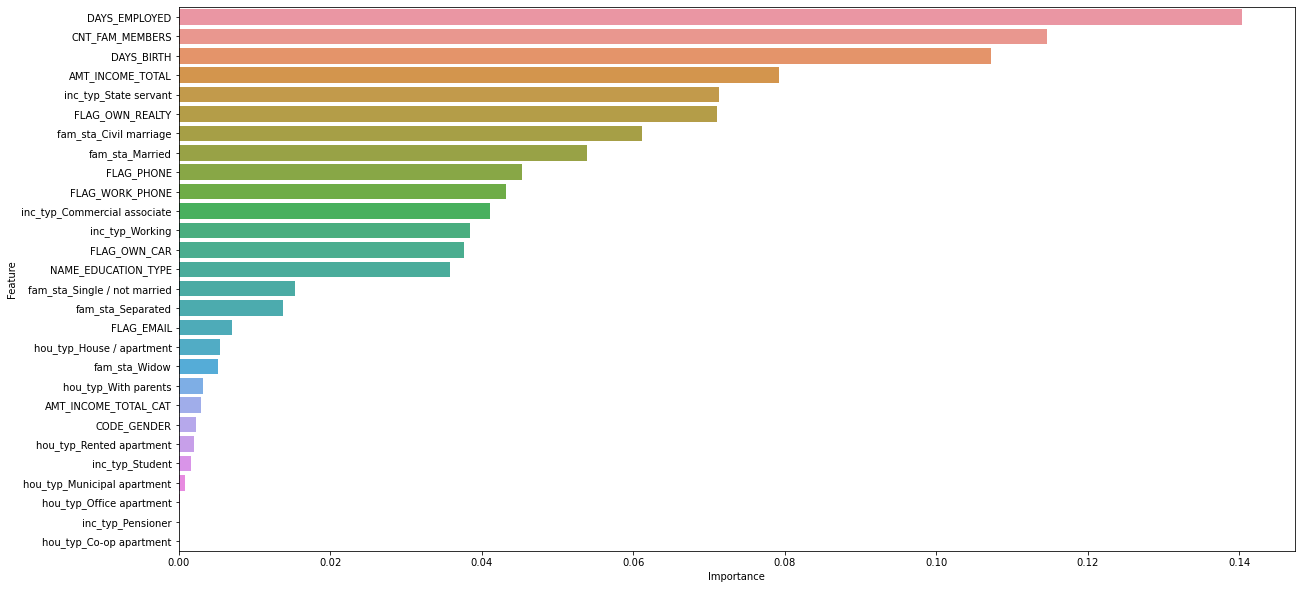

In [71]:
model = grid_dt_clf.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))


# Feature importance
print("\n~~~~~~~~ Feature Importance ~~~~~~~~")
dt_imp_df = feat_import(model, X_train)

print(dt_imp_df.head(50), '\n')

fig = plt.figure(figsize=(20, 10))

sns.barplot(data=dt_imp_df, x="Importance", y="Feature")

plt.show()

#### SVM

In [ ]:
model = grid_svm_clf.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Training set
print("------------------------Training Set------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("Training Set Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Training Set Precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("Training Set Recall: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("Training Set f1: {:.4f}".format(f1_score(y_train, y_train_pred)))


# Test set
print("\n--------------------------Test Set--------------------------")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Test Set Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Test Set Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("Test Set Recall: {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Test Set f1: {:.4f}".format(f1_score(y_test, y_test_pred)))

## Conclusion

+ The main research questions/ hypothesis were to check if the applicants with higher annual income or higher education level have a higher likelihood of getting credit card approval than the lower income/ education level applicants. Based on the outcomes of the two hypothesis testings done using *total income* and *education level* attributes, it can be concluded that:

    + **Total Income:** Applicants with a higher total income have a higher chance of getting the credit card approval

    + **Education Level**: There is not enough evidence to support the claim that the distribution of education level is different for those who got their loan approved versus those who did not. (i.e. distribution of the education level is the same for those who got their credit card approved versus those who did not.)

+ Education level is not identified as a discriminative feature in deciding the target class in decision tree model.

+ People with higher education level such as academic degree have not much applied for credit cards, which in general can be the reason of having a higher total income. (diagnostic analysis). Out of those academic degree holding applicants also, none of them have been identified as high-risk applicants.

+ A simple *kNN classifier* (using 3 nearest neighbors) can be used to predict the risk category of the applicants with a *recall of 90%*.
